## **Environment Setup**

In [1]:
import os 
os.chdir ('../src')

## **Importing Libraries**

In [2]:
from init import pd, ROOT_PATH
from knowledge_graph import load_data, plot_graph
from knowledge_graph import extract_sub_obj, get_question, answer

## **Reading the data**

In [3]:
candidate_sentences = pd.read_csv(ROOT_PATH + "data/wiki_sentences_v2.csv")
candidate_sentences = candidate_sentences.head(200)

## **Loading Entity Pairs and Relations**

In [4]:
print("Loading Data...")
entity_pairs, relations = load_data(
        candidate_sentences["sentence"])

Loading Data...


100%|██████████| 200/200 [00:03<00:00, 50.59it/s]


## **Extract Subject & Object**

In [5]:
source, target = extract_sub_obj(entity_pairs)

## **Create a Knowledge Graph Dataframe**

In [6]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

## **Get Question from User**

In [7]:
subject, edge = get_question()

Enter your question:


## **Obtain answer from Knowledge Graph**

In [8]:
answer(kg_df, subject, edge)

mall cop is recent  trend


## **Plot Knowledge Graph**

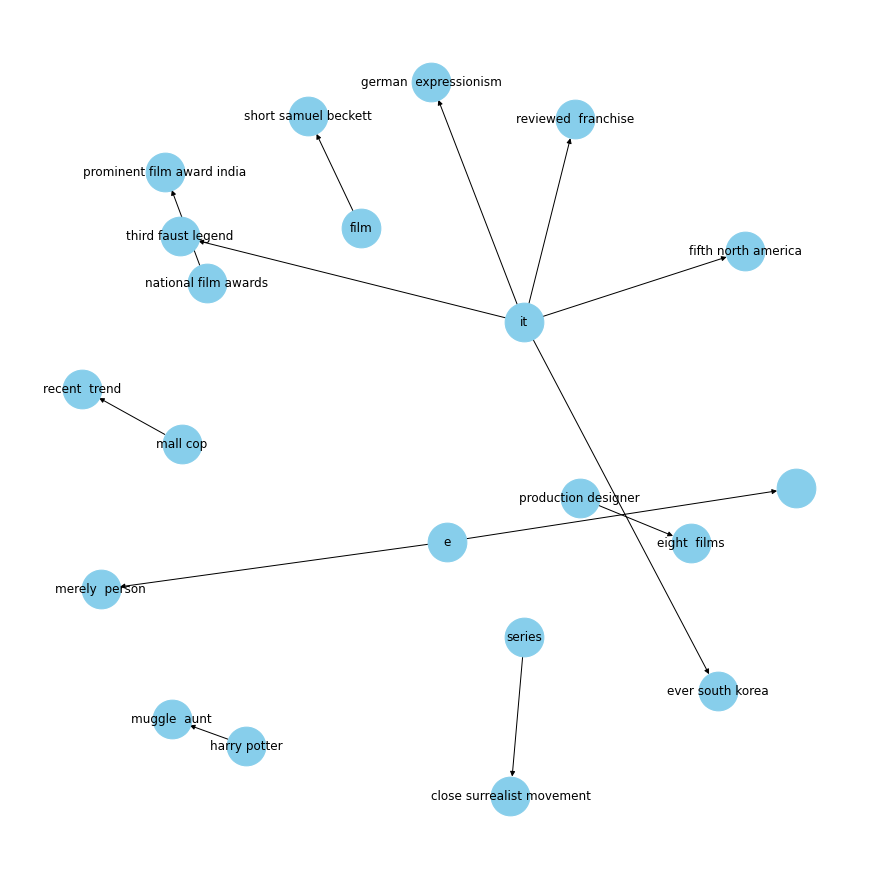

In [9]:
plot_graph(kg_df, edge)